# Appendix: Maximal class input

In this section, we optimize an image $\boldsymbol{\mathsf{x}}$ that maximizes a given class $c.$ The loss function we will use is $-f_c(\boldsymbol{\mathsf{x}}) + 0.1\| \boldsymbol{\mathsf{x}} \|^2$, i.e. we maximize the unnormalized class score instead of the class probability (since the latter can be maximized by decreasing the scores for the other classes). Note that the parameters of the model $f$ is fixed during optimization.

In [1]:
from chapter import *

In [2]:
from torchvision import models

class Input(nn.Module):
    def __init__(self):
        super().__init__()
        self.x = nn.Parameter(torch.rand(1, 3, 256, 256))

    def forward(self, _):
        return self.x


def maximal_class_input(c: int, num_steps=200, lr=5.0, wd=0.1) -> torch.tensor:
    # https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/    
    
    vgg = models.vgg16(pretrained=True)
    model = nn.Sequential(Input(), vgg)
    for param in model[1].parameters():
        param.requires_grad = False

    optim = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    for _ in tqdm(range(num_steps)):
        loss = -model(None)[0, c]
        loss.backward()
        optim.step()
        optim.zero_grad()
    
    return model[0](None)

Here we initialize $\boldsymbol{\mathsf{x}}$ pixels from $U[0, 1]$ and implemented as module parameters. This is prepended to a VGG16 model whose parameters are frozen. Weight decay is used to get more pixel variation across the input field (i.e. more clusters of visual features).

  0%|          | 0/200 [00:00<?, ?it/s]

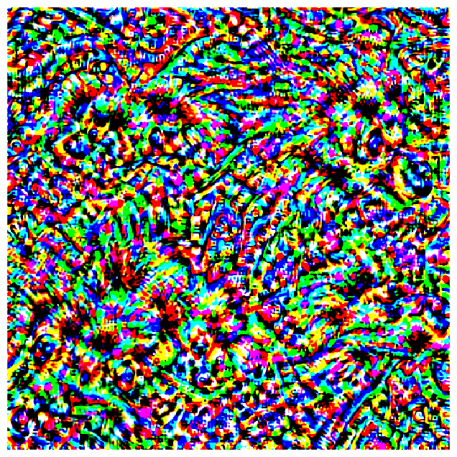

In [3]:
from torchvision.transforms.functional import adjust_sharpness

def normalize(x):
    """Map pixels to [0, 1]."""
    return (x - x.min()) / (x.max() - x.min())


x = maximal_class_input(259, num_steps=200, lr=5.0)    # pomeranian
x = nn.Upsample(scale_factor=2, mode="bilinear")(x)
x = adjust_sharpness(x, sharpness_factor=0.0)
x = normalize(x)
plt.figure(figsize=(8, 8))
plt.imshow(x[0].permute(1, 2, 0).detach().cpu().numpy())
plt.axis("off");

**Figure.** You may not like it, but this is what the ideal pomeranian looks like.